In [1]:
import numpy as np
import cv2
import json
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# Prepare the function to display the image and points

In [3]:
def display_image(image, title='Image'):
    plt.figure()
    plt.imshow(image)
    plt.title(title)
    plt.axis('off')
    plt.show()



def display_xyz(xyz, title='Point Cloud'):
    fig = go.Figure(data=[go.Scatter3d(
        x=xyz[:, 0],
        y=xyz[:, 1],
        z=xyz[:, 2],
        mode='markers',
        marker=dict(
            size=2,
            color=xyz[:, 2],
            colorscale='Viridis',
            opacity=0.8
        )
    )])
    fig.update_layout(scene_aspectmode='cube', title=title)
    fig.show()

# Read RGB Image

- When we use the `cv2.imread()` function to read an image, it reads the image in the BGR format.
- For each color channel, the pixel values range from 0 to 255.
- We can convert the image to RGB format using the `cv2.cvtColor()` function.

In [4]:
def read_rgb_image(image_file):
    image = cv2.imread(image_file, cv2.IMREAD_COLOR)    # By default, OpenCV reads images in BGR format
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)    # Convert BGR to RGB
    return image

RGB Image Shape:  (480, 640, 3)
RGB Image Type:  uint8


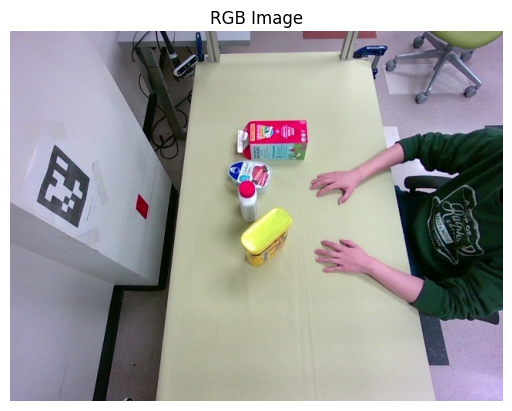

In [5]:
image_file = "../data/recordings/20231022_193630/105322251564/color_000000.jpg"
rgb_img = read_rgb_image(image_file)

print("RGB Image Shape: ", rgb_img.shape)
print("RGB Image Type: ", rgb_img.dtype)

display_image(rgb_img, title='RGB Image')

# Read Depth Image

- The depth value is stored in the 16-bit image in mm.
- Normally, we need to convert it to meters by dividing by 1000.

Depth Image Shape:  (480, 640)
Depth Image Type:  uint16
Depth Image range:  0 1498
Depth Image range:  0.0 1.498


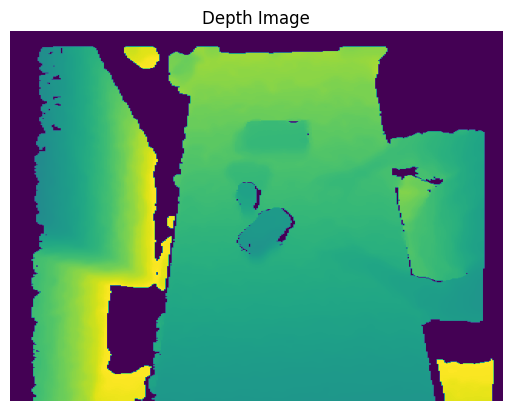

In [6]:
def read_depth_image(image_file):
    depth_image = cv2.imread(image_file, cv2.IMREAD_ANYDEPTH)
    return depth_image

depth_image_file = "../data/recordings/20231022_193630/105322251564/depth_000000.png"
depth_img = read_depth_image(depth_image_file)

print("Depth Image Shape: ", depth_img.shape)
print("Depth Image Type: ", depth_img.dtype)
print("Depth Image range: ", np.min(depth_img), np.max(depth_img))

depth_img = depth_img.astype(np.float32) / 1000.0    # Convert depth values from mm to meters
print("Depth Image range: ", np.min(depth_img), np.max(depth_img))

display_image(depth_img, title='Depth Image')

## Load the K matrix for the 

- The camera intrinsic is stored as a JSON file in following format.
- We can load the JSON file using the `json.load()` function.
- Because the depth image is aligned with the RGB image, we can use the same color intrinsics for both images.
- The loaded data is stored in a dictionary format. We will create the $K$ matrix from the dictionary.

```json
{
    "serial": "105322251564",
    "color": {
        "width": 640,
        "height": 480,
        "fx": 378.30926513671875,
        "fy": 378.024658203125,
        "ppx": 323.66534423828125,
        "ppy": 253.562744140625,
        "coeffs": [
            -0.05498598515987396,
            0.06602264940738678,
            -0.000507863238453865,
            0.0001927213161252439,
            -0.020694954320788383
        ]
    },
    "depth": ...,
    "depth2color": ...
}
```

In [ ]:
def read_data_from_json(json_file):
    with open(str(json_file), "r", encoding="utf-8") as f:
        data = json.load(f)
    return data

In [ ]:
# Read intrinsics from JSON file as a dictionary
json_file = "../data/calibration/intrinsics/105322251564_640x480.json"
intrinsics = read_data_from_json(json_file)

print(intrinsics)

In [ ]:
# Create the camera matrix
K = np.array(
    [
        [intrinsics["color"]["fx"], 0, intrinsics["color"]["ppx"]],
        [0, intrinsics["color"]["fy"], intrinsics["color"]["ppy"]],
        [0, 0, 1],
    ],
    dtype=np.float32
)

print("Camera K Matrix: \n", K)

### Create Point Cloud from Depth Image

#### Camera Intrinsics

The camera intrinsics matrix $K$ relates the 3D coordinates in the camera frame to the 2D coordinates in the image plane. It includes the focal lengths $(f_x, f_y)$ and the principal point offsets $(c_x, c_y)$.

$K = \begin{bmatrix} f_x & 0 & c_x \\ 0 & f_y & c_y \\ 0 & 0 & 1 \end{bmatrix}$

#### Camera Intrinsics Inverse

The inverse of the camera intrinsics matrix $K^{-1}$ can be used for backprojection.

$K^{-1} = \begin{bmatrix} 1/f_x & 0 & -c_x/f_x \\ 0 & 1/f_y & -c_y/f_y \\ 0 & 0 & 1 \end{bmatrix}$

#### Camera Extrinsics

The camera extrinsics matrix $[R|t]$ describes the transformation from the world coordinate system to the camera coordinate system. It includes a rotation matrix $R$ and a translation vector $t$.

$[R|t] = \begin{bmatrix} R & t \\ 0 & 1 \end{bmatrix}$

#### Projection of a 3D Point (x, y, z) to a 2D Point (u, v)

- To project a 3D point $(x, y, z)$ in the camera coordinate system to a 2D point $(u, v)$ in the image plane:

$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = K \cdot \begin{bmatrix} x \\ y \\ z \end{bmatrix}$

- Expanding this equation, we get:

$\begin{bmatrix} u \\ v \\ 1 \end{bmatrix} = \begin{bmatrix} f_x \cdot \frac{x}{z} + c_x \\ f_y \cdot \frac{y}{z} + c_y \\ 1 \end{bmatrix}$

#### Backprojection of a 2D Point (u, v) to a 3D Point (x, y, z)

- To backproject a 2D point $(u, v)$ from the image plane to a 3D point $(x, y, z)$ in the camera coordinate system, given a depth value $z$:

$\begin{bmatrix} x \\ y \\ z \end{bmatrix} = K^{-1} \cdot \begin{bmatrix} u \\ v \\ 1 \end{bmatrix} \cdot z$

- Expanding this equation, we get:

$\begin{bmatrix} x \\ y \\ z \end{bmatrix} = \begin{bmatrix} (u - c_x) \cdot \frac{z}{f_x} \\ (v - c_y) \cdot \frac{z}{f_y} \\ z \end{bmatrix}$

Given the $(u, v)$ pixel coordinates in the depth image and the depth value $d$ at that pixel, we can deproject the pixel to a 3D point in the camera coordinate frame.

$\begin{bmatrix} x \\ y \\ z \end{bmatrix} = \begin{bmatrix} (u - c_x) \cdot \frac{z}{f_x} \\ (v - c_y) \cdot \frac{z}{f_y} \\ z \end{bmatrix}$

In [ ]:
def get_xyz_from_uvd(u, v, d, fx, fy, cx, cy):
    x = (u - cx) * d / fx
    y = (v - cy) * d / fy
    z = d
    return np.array([x, y, z], dtype=np.float32)

In [ ]:
points = []

# Get the points by iterating over the depth image
height, width = depth_img.shape
for u in range(width):
    for v in range(height):
        d = depth_img[v, u]
        xyz = get_xyz_from_uvd(u, v, d, K[0, 0], K[1, 1], K[0, 2], K[1, 2])
        points.append(xyz)

# Convert the list of points to a numpy array
points = np.array(points)

print("Points Shape: ", points.shape, points.dtype)

display_xyz(points, title='XYZ')

Using the lookup table for the depth image, we can get the depth value at each pixel. We can then use the camera intrinsics to convert the pixel to a 3D point, but it takes a lot of time to do this for every pixel in the image.

Instead, we will use the matrix multiplication to convert the depth image to a point cloud in a single step.

${cam\_coords} = {K\_inv} \cdot {pixel\_coords} \cdot {depths}$

$P$ = $K^{-1} \cdot \begin{bmatrix} u_1 & ... & u_{H \cdot W} \\ v_1 & ... & u_{H \cdot W} \\ 1 & ... & 1 \end{bmatrix} \cdot \begin{bmatrix} d_1 \\ ... \\ d_{H \cdot W}\end{bmatrix}$

In [ ]:
def deproject_depth_image(depth_img, K):
    height, width = depth_img.shape

    # use function np.linalg.inv to compute the inverse of the camera intrinsic matrix
    K_inv = np.linalg.inv(K)

    # use function np.meshgrid to construct the pixel coordinates
    # and then convert the pixel coordinates into homogenenous coordinates
    u, v = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')
    ones = np.ones((height, width))
    pixel_coords = np.stack([u, v, ones], axis=-1, dtype=np.float32)   # (height, width, 3)

    # reshape the pixel coordinates to a 2D array
    pixel_coords = pixel_coords.reshape(-1, 3)    # (height*width, 3)
    pixel_coords = pixel_coords.T    # (3, height*width)

    # reshape the depth image to a 1D array
    depths = depth_img.reshape(-1)   # d is a 1D array

    # compute the 3D coordinates of the pixels
    cam_coords = (K_inv @ pixel_coords) * depths
    cam_coords = cam_coords.T    # (height*width, 3)

    return cam_coords

In [ ]:
points = deproject_depth_image(depth_img, K)

print("Points Shape: ", points.shape, points.dtype)

display_xyz(points, title='XYZ')